# Functions and imports declaration

In [32]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import datetime
#Function declaration
 #these are just the functions that'll be used later in the code

def CleanHolidays(dfi, hol):
    #dfi["WorkHour"] = True
    dfi["Holiday"] = False
    for i in hol:
        date = i
        datel = date.split(".")
        #for j in range(len(datel)):
            #datel[j] = datel[j].strip("0")
        d = str(datel[0] + "-" + datel[1] + "-" + datel[2])
        index_names = dfi[dfi['Date'].str.contains(d)].index
        dfi.loc[index_names, "Holiday"] = True
    dfi.reset_index(drop=True, inplace=True)
    return dfi

def NaNcheck(dfi):
    c = 0
    f = 0
    for i in dfi.iterrows():
        if "NaN" in str(i):
            print("NaN present at row n° " + str(c) + " in " + str(i))
            f = 1
        else:
            c += 1
    if f == 0: print("NaN check ok")
    return c

def AddMeteo(dfm, dfi):
    dfi["temp_C"] = dfm["temp_C"]
    dfi["solarRad_W/m2"] = dfm["solarRad_W/m2"]
    dfi["windSpeed_m/s"]=dfm["windSpeed_m/s"]
    dfi["rain_day"]=dfm["rain_day"]
    return dfi

def AddWeekDay(dfi):
    w = []
    ci=8760
    for i in range(ci):
        for j in range(24):
            r = i // 7
            w.append(str(i - (i // 7) * 7))
    dw = pd.DataFrame(w)
    dfi["WeekDay"]=dw
    dfi.reset_index(drop=True, inplace=True)
    return dfi

#def AddDayHour(dfi):
    #dfi["Date_start"] = pd.to_datetime(dfi["Date_start"])
    #dfi['Date'] = dfi['Date_start'].dt.strftime('%d-%m-%Y')
    #dfi['Hour'] = dfi['Date_start'].dt.strftime('%H')
    #return dfi
def RearrangeCol(dfi):
    dfi=dfi[["Date_start","Date","Hour","Power_kW","WeekDay","temp_C","solarRad_W/m2","Holiday","Season", "rain_day","Season_name"]]
    return dfi
def RearrangeCol_2(dfi):
    dfi=dfi[["Date_start","Date","Hour","Power_kW","WeekDay","temp_C","solarRad_W/m2","Holiday","Season", "rain_day","Power-1","Season_name"]]
    return dfi
def AddSeason(dfi):
    dfi.loc[:1898, "Season"]= 1
    dfi.loc[:1898, "Season_name"]= "Winter"
    dfi.loc[1898:4105,"Season"] = 2
    dfi.loc[1898:4105,"Season_name"] = "Spring"
    dfi.loc[4105:6313, "Season"] = 3
    dfi.loc[4105:6313, "Season_name"] = "Summer"
    dfi.loc[6313:8474, "Season"] = 4
    dfi.loc[6313:8474, "Season_name"] = "Autumn"
    dfi.loc[8474:,"Season"] = 1
    dfi.loc[8474:,"Season_name"] = "Winter"
    return(dfi)

def IQRClean(dfi):
    Q1 = dfi['Power_kW'].quantile(0.25)
    Q3 = dfi['Power_kW'].quantile(0.75)
    IQR = Q3 - Q1
    dfi = dfi[((dfi['Power_kW'] > (Q1 - 1.5 * IQR)) & (dfi['Power_kW'] < (Q3 + 1.5 * IQR)))]
    dfi["Power_kW"] = dfi["Power_kW"].interpolate(method="linear")
    return dfi

def fixdates(dfi,flagy):
    #dfi["Date_start"] = pd.to_datetime(dfi["Date_start"])
    d=[]
    he=[]
    h=[]
    merge=[]
    f=0
    gg=0
    mm=0
    if flagy==17: aa="2017"
    if flagy==18: aa="2018"
    g31=[1,3,5,7,8,10,12]
    g30=[4,6,9,11]
    for mm in range(1, 13):
        if mm in g31:
            gm = 31
        elif mm in g30:
            gm = 30
        else:
            gm = 28
        for gg in range(1,gm+1):
            if len(str(gg))<2:
                gg="0" + str(gg)
            if len(str(mm))<2:
                mm="0" +str(mm)
            for jj in range(24):
                d.append(str(gg)+ "-"+ str(mm)+ "-" + aa)
    print("length is:", len(d))
    for j in range(365):
        for i in range(24):
            he.append(i)
            if len(str(i))<2:
                i="0"+ str(i)
            hh=str(i)+ ":00:00"
            h.append(hh)
    for i in range(len(d)):
        merge.append(d[i] + " " + h[i])
    dff = pd.DataFrame(merge)
    ddf=pd.DataFrame(d)
    dhf=pd.DataFrame(he)
    dfi["Date_start"]=dff
    dfi["Date"]=ddf
    dfi["Hour"]=dhf
    #dfi["Date_start"]=pd.to_datetime(dfi["Date_start"],format="%d-%m-%Y %H:%M:%S")
    return(dfi)

def Bootstrapping():

    df_data=pd.read_csv('final.csv')
    df_data['Date_start'] = pd.to_datetime (df_data['Date_start'], format="%Y-%m-%d %H:%M:%S") # create a new column 'data time' of datetime type
    df_data = df_data.set_index('Date_start') # make 'datetime' into index
    print(df_data.head())

    # recurrent
    X=df_data.values
    Y=X[:,2]
    X=X[:,[1,3,4,5,6,7,9]] 
    X_train, X_test, y_train, y_test = train_test_split(X,Y)
    #print(X_train)
    #print(y_train)

    from sklearn.ensemble import BaggingRegressor

    BT_model = BaggingRegressor()
    BT_model.fit(X_train, y_train)
    y_pred_BT =BT_model.predict(X_test)

    MAE_BT=metrics.mean_absolute_error(y_test,y_pred_BT) 
    MSE_BT=metrics.mean_squared_error(y_test,y_pred_BT)  
    RMSE_BT= np.sqrt(metrics.mean_squared_error(y_test,y_pred_BT))
    cvRMSE_BT=RMSE_BT/np.mean(y_test)
    print("\n")
    print(MAE_BT,MSE_BT,RMSE_BT,cvRMSE_BT)

    plt.plot(y_test[1:200])
    plt.plot(y_pred_BT[1:200])
    plt.show()
    plt.scatter(y_test,y_pred_BT)
    dfdata=pd.DataFrame(y_test)
    dfdata.rename(columns={dfdata.columns[0]: "y_test"}, inplace=True)
    dfdata["y_pred"]=pd.DataFrame(y_pred_BT)
    dfdata.to_csv("dfdata_2017.csv")
    derr=[MAE_BT,MSE_BT,RMSE_BT,cvRMSE_BT]
    dferr=pd.DataFrame(derr)
    dferr.to_csv("err_2017.csv")


# MAIN

In [2]:

#data reading
df_raw17=pd.read_csv("IST_South_Tower_2017_Ene_Cons.csv")
df_raw18=pd.read_csv("IST_South_Tower_2018_Ene_Cons.csv")
#meteo cleaning
dfm = pd.read_csv("IST_meteo_data_2017_2018_2019.csv")
dfm.rename(columns={'yyyy-mm-dd hh:mm:ss': 'Date'}, inplace=True)
dfm=dfm.iloc[::12]
dfm.reset_index(drop=True, inplace=True)
# checking existing NaN values
print("NaNcheck before cleaning:")
#NaNcheck(df_raw)
df_raw17=fixdates(df_raw17,17)
df_raw18=fixdates(df_raw18,18)
# Adding WD, tempc and solarrad
df_raw17=AddWeekDay(df_raw17)
df_raw17=AddMeteo(dfm, df_raw17)
df_raw17 = AddSeason(df_raw17)
df_raw18=AddWeekDay(df_raw18)
df_raw18=AddMeteo(dfm, df_raw18)
df_raw18 = AddSeason(df_raw18)
hol=pd.read_csv("holiday_17_18_19.csv")
hol=hol.iloc[:, 0]
# Cleaning holidays + reset indexes
df17=CleanHolidays(df_raw17, hol)
df18=CleanHolidays(df_raw18,hol)
#df= AddDayHour(df)
#print("Check4")
#print(df)
df17=RearrangeCol(df17)
df18=RearrangeCol(df18)
#df.set_index('Date_start', inplace=True)
df17['Power-1'] = df17['Power_kW'].shift(1, fill_value=df17["Power_kW"].iloc[-1])
df18['Power-1'] = df18['Power_kW'].shift(1, fill_value=df18["Power_kW"].iloc[-1])
df17=RearrangeCol_2(df17)
df18=RearrangeCol_2(df18)
df17['Date_start']= pd.to_datetime(df17['Date_start'],dayfirst=True)
df18['Date_start']= pd.to_datetime(df18['Date_start'],dayfirst=True)
df18["hour"]=df18["Hour"]
df17["hour"]=df17["Hour"]
df17['Hour'] = pd.to_datetime(df17['Hour'],format= '%H' ).dt.time
df18['Hour'] = pd.to_datetime(df18['Hour'],format= '%H' ).dt.time
df17.set_index('Date_start', inplace=True)
df18.set_index('Date_start', inplace=True)
#Outliers cleaning  
print("NaNcheck after cleaning:")
#NaNcheck(df)

NaNcheck before cleaning:
length is: 8760
length is: 8760
NaNcheck after cleaning:


# Merge

In [3]:
df=pd.concat([df17, df18])
df

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2017-01-01 00:00:00,01-01-2017,00:00:00,100.810001,0,8.720,1.163,True,1.0,0.0,79.176097,Winter,0
2017-01-01 01:00:00,01-01-2017,01:00:00,99.054135,0,8.210,1.357,True,1.0,0.0,100.810001,Winter,1
2017-01-01 02:00:00,01-01-2017,02:00:00,98.539567,0,7.580,2.604,True,1.0,0.0,99.054135,Winter,2
2017-01-01 03:00:00,01-01-2017,03:00:00,101.435784,0,6.968,1.440,True,1.0,0.0,98.539567,Winter,3
2017-01-01 04:00:00,01-01-2017,04:00:00,98.481665,0,6.797,1.773,True,1.0,0.0,101.435784,Winter,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,31-12-2018,19:00:00,97.217861,0,11.880,542.500,False,1.0,0.0,105.247736,Winter,19
2018-12-31 20:00:00,31-12-2018,20:00:00,95.928710,0,12.190,503.200,False,1.0,0.0,97.217861,Winter,20
2018-12-31 21:00:00,31-12-2018,21:00:00,85.652000,0,11.330,311.200,False,1.0,0.0,95.928710,Winter,21


# Exploratory data analysis

## Plot data

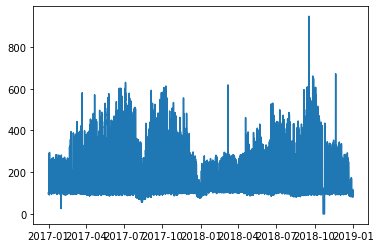

In [4]:
plt.plot(df["Power_kW"])

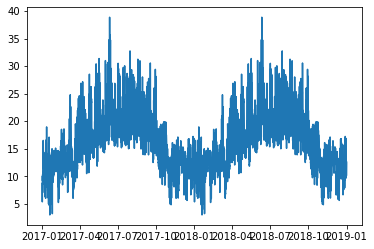

In [5]:
plt.plot(df["temp_C"])

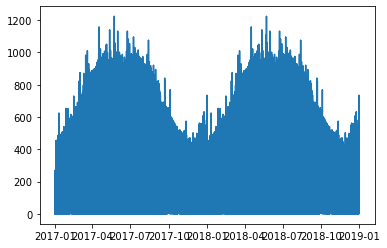

In [6]:
plt.plot(df["solarRad_W/m2"])

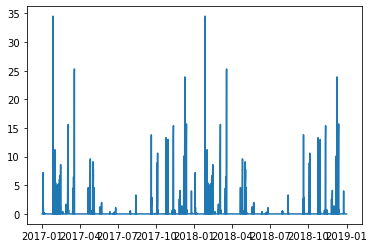

In [7]:
plt.plot(df["rain_day"])

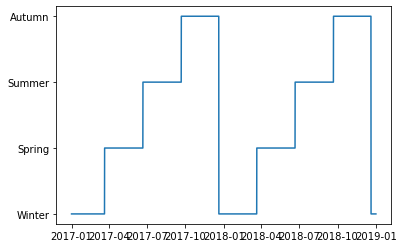

In [8]:
plt.plot(df["Season_name"])

(array([8.800e+01, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        4.200e+01, 1.250e+02, 3.830e+02, 1.444e+03, 3.892e+03, 3.252e+03,
        9.570e+02, 4.240e+02, 3.540e+02, 2.860e+02, 1.860e+02, 1.620e+02,
        2.090e+02, 2.090e+02, 1.480e+02, 1.490e+02, 1.770e+02, 2.140e+02,
        2.630e+02, 3.050e+02, 3.250e+02, 3.050e+02, 2.600e+02, 2.380e+02,
        1.800e+02, 1.940e+02, 2.280e+02, 1.770e+02, 1.670e+02, 1.720e+02,
        1.460e+02, 1.470e+02, 1.520e+02, 1.430e+02, 1.310e+02, 1.380e+02,
        1.220e+02, 1.160e+02, 9.400e+01, 8.600e+01, 8.800e+01, 8.700e+01,
        6.200e+01, 6.500e+01, 5.100e+01, 5.100e+01, 4.800e+01, 5.000e+01,
        3.400e+01, 3.700e+01, 2.700e+01, 2.400e+01, 1.800e+01, 1.400e+01,
        1.000e+01, 1.300e+01, 8.000e+00, 1.200e+01, 7.000e+00, 4.000e+00,
        3.000e+00, 8.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

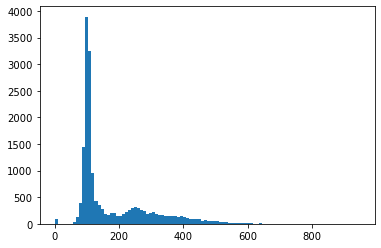

In [9]:
plt.hist(df["Power_kW"],100)

(array([  36.,  206.,  552., 1164., 2024., 2466., 2308., 2416., 2108.,
        1516., 1044.,  660.,  424.,  312.,  160.,   72.,   14.,   22.,
          10.,    6.]),
 array([ 3.014 ,  4.8063,  6.5986,  8.3909, 10.1832, 11.9755, 13.7678,
        15.5601, 17.3524, 19.1447, 20.937 , 22.7293, 24.5216, 26.3139,
        28.1062, 29.8985, 31.6908, 33.4831, 35.2754, 37.0677, 38.86  ]),
 <BarContainer object of 20 artists>)

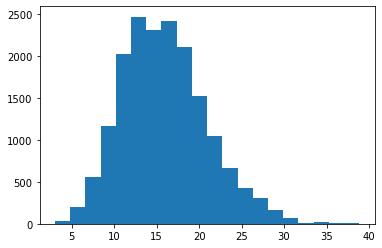

In [10]:
plt.hist(df["temp_C"],20)

## Data analysis

### Power consumption vs working/holiday days

In [11]:
#splitting between holiday data and working days data
df_hol=df[(df["Holiday"]==True) | (df["WeekDay"]==6)]
df_workd=df[(df["Holiday"]==False) & (df["WeekDay"] !=6)]
df_workd

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2017-01-02 00:00:00,02-01-2017,00:00:00,92.215521,1,9.64,1.496,False,1.0,0.0,97.656390,Winter,0
2017-01-02 01:00:00,02-01-2017,01:00:00,94.693530,1,9.57,1.136,False,1.0,0.0,92.215521,Winter,1
2017-01-02 02:00:00,02-01-2017,02:00:00,97.909850,1,9.97,2.521,False,1.0,0.0,94.693530,Winter,2
2017-01-02 03:00:00,02-01-2017,03:00:00,95.432934,1,9.80,1.329,False,1.0,0.0,97.909850,Winter,3
2017-01-02 04:00:00,02-01-2017,04:00:00,95.678309,1,9.83,2.520,False,1.0,0.0,95.432934,Winter,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,31-12-2018,19:00:00,97.217861,0,11.88,542.500,False,1.0,0.0,105.247736,Winter,19
2018-12-31 20:00:00,31-12-2018,20:00:00,95.928710,0,12.19,503.200,False,1.0,0.0,97.217861,Winter,20
2018-12-31 21:00:00,31-12-2018,21:00:00,85.652000,0,11.33,311.200,False,1.0,0.0,95.928710,Winter,21


(50.0, 500.0)

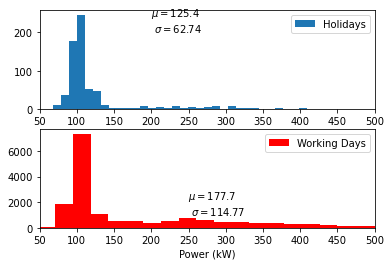

In [12]:
powHol=df_hol["Power_kW"]
powWD=df_workd["Power_kW"]
#Compute mu and sigma
mu_powHol=np.mean(powHol)
sig_powHol=np.std(powHol)
mu_powWD=np.mean(powWD)
sig_powWD=np.std(powWD)
#Draw the actual histograms
fig2, ax2=plt.subplots(2,1)
infoHol=f"$\mu={mu_powHol:.1f}$\n $\sigma={sig_powHol:.2f}$"
infoWD=f"$\mu={mu_powWD:.1f}$\n $\sigma={sig_powWD:.2f}$"
ax2[0].hist(powHol,bins=40, label="Holidays")
ax2[0].text(200,200,infoHol)
ax2[0].legend()
ax2[0].set_xlim(50,500)
ax2[1].hist(powWD,bins=40, label="Working Days", color="red")
ax2[1].text(250, 1000, infoWD)
ax2[1].legend()
ax2[1].set_xlabel("Power (kW)")
ax2[1].set_xlim(50,500)

### Power consumption vs working hours/not working hours

In [13]:
#without considering holidays
df_wh=df_workd.between_time('08:00:00', '20:00:00')
df_notwh=df_workd.between_time('21:00:00','07:00:00')
df_wh

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2017-01-02 08:00:00,02-01-2017,08:00:00,283.762017,1,10.16,1.495,False,1.0,0.0,133.987914,Winter,8
2017-01-02 09:00:00,02-01-2017,09:00:00,240.998945,1,10.15,31.380,False,1.0,0.0,283.762017,Winter,9
2017-01-02 10:00:00,02-01-2017,10:00:00,263.492864,1,10.75,59.380,False,1.0,0.0,240.998945,Winter,10
2017-01-02 11:00:00,02-01-2017,11:00:00,280.419186,1,11.21,53.120,False,1.0,0.0,263.492864,Winter,11
2017-01-02 12:00:00,02-01-2017,12:00:00,279.796461,1,12.36,107.600,False,1.0,0.0,280.419186,Winter,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 16:00:00,31-12-2018,16:00:00,103.270310,0,11.73,112.400,False,1.0,0.0,109.388311,Winter,16
2018-12-31 17:00:00,31-12-2018,17:00:00,102.152465,0,11.95,675.500,False,1.0,0.0,103.270310,Winter,17
2018-12-31 18:00:00,31-12-2018,18:00:00,105.247736,0,12.70,735.000,False,1.0,0.0,102.152465,Winter,18


Text(0, 0.5, 'P [kW]')

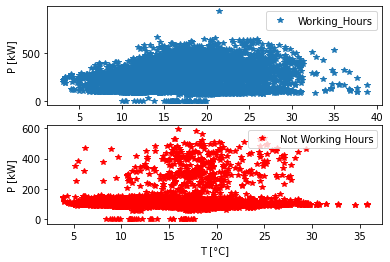

In [14]:
fig5, ax5=plt.subplots(2,1)
xWH=df_wh["temp_C"]
yWH=df_wh["Power_kW"]
ax5[0].plot(xWH,yWH,"*",label="Working_Hours")
ax5[0].set_ylabel("P [kW]")
ax5[0].legend()
xNWH=df_notwh["temp_C"]
yNWH=df_notwh["Power_kW"]
ax5[1].plot(xNWH,yNWH,"*",label="Not Working Hours",color="red")
ax5[1].legend()
ax5[1].set_xlabel("T [°C]")
ax5[1].set_ylabel("P [kW]")

# As we can see there is some correlation between hour and temperature only on working hours, 
# otherwise it is mostly below 200 kW

(50.0, 500.0)

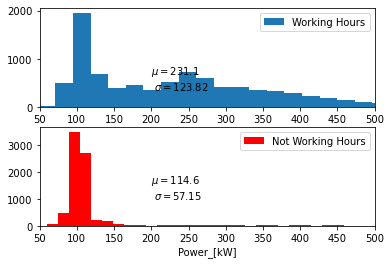

In [15]:
powWH=df_wh["Power_kW"]
powNWH=df_notwh["Power_kW"]
#Compute mu and sigma of power during holidays and working days
mu_powWH=np.mean(powWH)
sig_powWH=np.std(powWH)
mu_powNWH=np.mean(powNWH)
sig_powNWH=np.std(powNWH)
#Draw the actual histograms
fig6, ax6=plt.subplots(2,1)
infoWH=f"$\mu={mu_powWH:.1f}$\n $\sigma={sig_powWH:.2f}$"
infoNWH=f"$\mu={mu_powNWH:.1f}$\n $\sigma={sig_powNWH:.2f}$"
ax6[0].hist(powWH,bins=40, label="Working Hours")
ax6[0].text(200,350,infoWH)
ax6[0].legend()
ax6[0].set_xlim(50,500)
ax6[1].hist(powNWH,bins=40, label="Not Working Hours", color="red")
ax6[1].text(200, 1000, infoNWH)
ax6[1].legend()
ax6[1].set_xlabel("Power_[kW]")
ax6[1].set_xlim(50,500)

#Regarding the working hours there are two main peaks, at 1000 kW and 400 kW (give or take)
#Regarding not working hours the consumption is much lower and much more constant throughout time, with a peak at 3000 kW (give or take)
#We can say that these two plots highlights even more the fact that there is a clear correlation between hour and consumption
#only during working days, otherwise it is pretty constant

## Basic statistics

In [16]:
df.describe()

,Power_kW,temp_C,solarRad_W/m2,Season,rain_day,Power-1,hour
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,175.731324,15.944250,198.557296,2.496119,0.553916,175.731324,11.500000
std,113.664489,5.011188,285.839433,1.114480,2.495952,113.664489,6.922384
min,0.000000,3.014000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,100.669286,12.230000,1.136000,2.000000,0.000000,100.669286,5.750000
50%,111.587622,15.570000,6.968000,2.000000,0.000000,111.587622,11.500000
75%,242.475295,18.990000,350.525000,3.000000,0.000000,242.475295,17.250000
max,947.059190,38.860000,1224.000000,4.000000,34.500000,947.059190,23.000000


In [17]:
df_sortkW = df.sort_values(by = 'Power_kW', ascending = True)
df_sortkW [:9]

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2018-10-22 15:00:00,22-10-2018,15:00:00,0.0,0,17.49,140.000,False,4.0,0.0,0.0,Autumn,15
2018-10-22 06:00:00,22-10-2018,06:00:00,0.0,0,8.41,3.269,False,4.0,0.0,0.0,Autumn,6
2018-10-22 07:00:00,22-10-2018,07:00:00,0.0,0,9.00,98.400,False,4.0,0.0,0.0,Autumn,7
2018-10-22 08:00:00,22-10-2018,08:00:00,0.0,0,10.34,250.700,False,4.0,0.0,0.0,Autumn,8
2018-10-22 09:00:00,22-10-2018,09:00:00,0.0,0,11.84,385.500,False,4.0,0.0,0.0,Autumn,9
2018-10-22 10:00:00,22-10-2018,10:00:00,0.0,0,15.88,519.800,False,4.0,0.0,0.0,Autumn,10
2018-10-22 11:00:00,22-10-2018,11:00:00,0.0,0,16.27,513.200,False,4.0,0.0,0.0,Autumn,11
2018-10-22 12:00:00,22-10-2018,12:00:00,0.0,0,18.44,494.800,False,4.0,0.0,0.0,Autumn,12
2018-10-22 13:00:00,22-10-2018,13:00:00,0.0,0,18.65,426.900,False,4.0,0.0,0.0,Autumn,13


In [18]:
df_sortkW = df.sort_values(by = 'Power_kW', ascending = False) 
df_sortkW [:9]

,Date,Hour,Power_kW,WeekDay,temp_C,solarRad_W/m2,Holiday,Season,rain_day,Power-1,Season_name,hour
Date_start,,,,,,,,,,,,
2018-09-17 16:00:00,17-09-2018,16:00:00,947.059190,0,21.48,1.910,False,3.0,0.0,621.344736,Summer,16
2018-11-20 15:00:00,20-11-2018,15:00:00,671.567397,1,14.17,34.330,False,4.0,0.0,306.022579,Autumn,15
2018-09-26 14:00:00,26-09-2018,14:00:00,660.638464,2,20.92,0.637,False,4.0,0.0,640.113886,Autumn,14
2018-09-27 11:00:00,27-09-2018,11:00:00,651.079090,3,19.63,223.700,False,4.0,0.0,640.703836,Autumn,11
2018-09-28 11:00:00,28-09-2018,11:00:00,649.392925,4,25.89,268.400,False,4.0,0.1,604.418414,Autumn,11
2018-09-27 10:00:00,27-09-2018,10:00:00,640.703836,3,20.41,435.400,False,4.0,0.0,608.274939,Autumn,10
2018-09-28 14:00:00,28-09-2018,14:00:00,640.317964,4,25.08,6.087,False,4.0,0.1,637.954450,Autumn,14
2018-09-26 13:00:00,26-09-2018,13:00:00,640.113886,2,23.03,2.020,False,4.0,0.0,637.925389,Autumn,13
2018-09-26 11:00:00,26-09-2018,11:00:00,638.449789,2,24.27,288.700,False,4.0,0.0,627.495511,Autumn,11


{'whiskers': [<matplotlib.lines.Line2D at 0x1ed9b54f700>,
 'caps': [<matplotlib.lines.Line2D at 0x1ed9b54fdc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ed9b54f3a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ed9b579460>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ed9b5797c0>],
 'means': []}

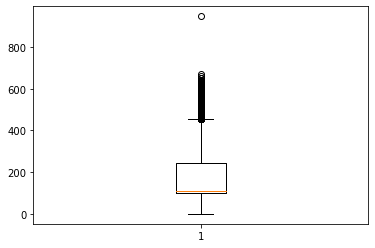

In [19]:
plt.boxplot(df['Power_kW'])

## Outliers removal

In [20]:
df17=IQRClean(df17)  
df18=IQRClean(df18)
df=IQRClean(df)

<ipython-input-1-1323431cb7f0>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi["Power_kW"] = dfi["Power_kW"].interpolate(method="linear")
<ipython-input-1-1323431cb7f0>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi["Power_kW"] = dfi["Power_kW"].interpolate(method="linear")
<ipython-input-1-1323431cb7f0>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

# Bootstrapping

### CSV generation 

In [22]:
df17.to_csv("final_2017.csv")
df18.to_csv("final_2018.csv")
df.to_csv("final.csv")
#the algorithms are made so that they get the datas from the final csv, not the dataframe

In [31]:
Bootstrapping()

                           Date      Hour    Power_kW  WeekDay  temp_C  \
Date_start                                                               
2017-01-01 00:00:00  01-01-2017  00:00:00  100.810001        0   8.720   
2017-01-01 01:00:00  01-01-2017  01:00:00   99.054135        0   8.210   
2017-01-01 02:00:00  01-01-2017  02:00:00   98.539567        0   7.580   
2017-01-01 03:00:00  01-01-2017  03:00:00  101.435784        0   6.968   
2017-01-01 04:00:00  01-01-2017  04:00:00   98.481664        0   6.797   

                     solarRad_W/m2  Holiday  Season  rain_day     Power-1  \
Date_start                                                                  
2017-01-01 00:00:00          1.163     True     1.0       0.0   79.176097   
2017-01-01 01:00:00          1.357     True     1.0       0.0  100.810001   
2017-01-01 02:00:00          2.604     True     1.0       0.0   99.054135   
2017-01-01 03:00:00          1.440     True     1.0       0.0   98.539567   
2017-01-01 04:00:00

ValueError: could not convert string to float: '08:00:00'